<a href="https://colab.research.google.com/github/adiag321/Customer-Segmentation-and-Analysis-of-Online-Retail/blob/main/1_Online_Retail_Segmentation_by_Buying_Category.ipynb" target="blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CUSTOMER SEGMENTAION AND ANALYSIS OF ONLINE RETAIL BUSINESS

## Part I - Item Based Segmentation (Segmentation by buying category)

## Introduction
In this notebook we perform customer segmantation of online retail customers based on their spending per product categories. The dataset used is [Online Retail II Data Set](https://archive.ics.uci.edu/ml/datasets/Online+Retail+II) from UC Irvine Machine Learning Repository. Unfortunately the dataset does not contain product categories. Hence we will have to create them. This is done by using topic modeling on product descriptions.

## 1. Loading libraries and fetching data


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import openpyxl
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, ENGLISH_STOP_WORDS
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans,MiniBatchKMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from wordcloud import WordCloud
sns.set_style("whitegrid")

import warnings
warnings.filterwarnings("ignore")

In [6]:
online_retail = pd.read_excel('/Users/adityaagarwal/Aditya Ag/Jupyter Notebook/Resume Projects/Customer Lifetime Value Prediction and Segmentation for Online Retail Business/data/online_retail_II.xlsx',sheet_name=None)

online_retail = online_retail['Year 2009-2010'].append(online_retail['Year 2010-2011'],ignore_index=True)

As we can see, the data set contains Invoice orders that can span multiple rows. Each row represents a specific item and has information on the purchase quantities, price, invoice date, customer ID, and customer country.

In [7]:
online_retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   Invoice      1067371 non-null  object        
 1   StockCode    1067371 non-null  object        
 2   Description  1062989 non-null  object        
 3   Quantity     1067371 non-null  int64         
 4   InvoiceDate  1067371 non-null  datetime64[ns]
 5   Price        1067371 non-null  float64       
 6   Customer ID  824364 non-null   float64       
 7   Country      1067371 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 65.1+ MB


Let's take a glimpse of the dataset

In [8]:
print("The shape of the dataset is", online_retail.shape)
online_retail.head()

The shape of the dataset is (1067371, 8)


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


### 1.1 Number of unique customers

In [10]:
print('Number of unique customers: {}'.format(len(online_retail['Customer ID'].unique())))

Number of unique customers: 5943


### 1.2 Number of unique descriptions

In [11]:
print('Number of unique descriptions: {}'.format(len(online_retail['Description'].unique())))

Number of unique descriptions: 5699


In [12]:
online_retail['Description'].value_counts()

WHITE HANGING HEART T-LIGHT HOLDER     5918
REGENCY CAKESTAND 3 TIER               4412
JUMBO BAG RED RETROSPOT                3469
ASSORTED COLOUR BIRD ORNAMENT          2958
PARTY BUNTING                          2765
                                       ... 
IVORY PENDANT SHELL NECKLACE              1
allocate stock for dotcom orders ta       1
PAINTED HEART WREATH WITH BELL            1
FLOWER FAIRY MUG+COASTER,ROSE             1
Zebra invcing error                       1
Name: Description, Length: 5698, dtype: int64

## 3. Item Based Segmentation

To perform an item based segmentation, we will `assign each item to specific category`. We could perform a segmentation on an item level but rolling up to categories has two benefits:

1. Since there exist 5,699 unique items using them would mean that we would have to work in a high dimensional space (i.e. a 5699-dimensional space). In general, high dimensional spaces tend to be problematic when clustering (ex. see discussion in “k-Means Advantages and Disadvantages” ).
2. it is easier to describe clusters if we use categories.

### 3.1 Product categories

Unfortunately, item categories are not available in the dataset. Hence, we must find a way to create them. To do this, we are going to perform clustering on items’ descriptions. We will use k-means clustering (or better a variant of k-means called MiniBatchKMeans). Since k-means works only on `numerical data` we map descriptions to high dimensional vectors. This is done using:

1. `TfidfVectorizer`
2. `Countvectorizer`

The two different methods will allow us to find the better way to model product categories.

### A) Data Preprocessing
First, we check for missing values in desctiption and replace them with 'NA".

In [13]:
online_retail['Description'].isna().sum()

4382

In [15]:
online_retail['Description'] = online_retail['Description'].fillna('NA')

Then, we
* convert 'Description' column to string (there is a cell wich is integer causing problem latter)
* create a list with unique descriptions

In [16]:
descriptions=online_retail['Description'].apply(str).unique()
print(descriptions.shape)

(5699,)


We would like to remove common words from our analyses. One way to find them is to create a word cloud from all descriptions.

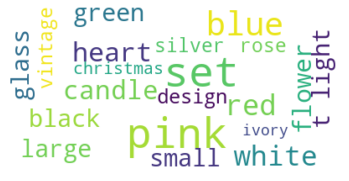

In [31]:
text=[t.lower() for t in descriptions]
#text=text.cat(sep=' ')
#text=text.lower()
text=' '.join([word for word in text])
#text=' '.join([word for word in text.split()])
wordcloud = WordCloud(max_font_size=50, max_words=20, 
                      background_color="white",stopwords=ENGLISH_STOP_WORDS).generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Based on the word cloud, we create our stopwords list.

In [25]:
custom_stopwords=ENGLISH_STOP_WORDS.union(['small', 'big','large','light','black', 'red', 'blue', 'green', 
                                           'white', 'black', 'pink','glass','ivory', 'metal', 'silver','zinc',
                                           'set','vintage','design'])


### 1. Using TfidfVectorizer

Apply TfidfVectorizer on descriptions.

In [40]:
vectorizer = TfidfVectorizer(stop_words = custom_stopwords) #default stop_words={'english'}
X_tfidf = vectorizer.fit_transform(descriptions) 
print(X_tfidf.shape)

(5699, 2541)


Use elbow criterion for determining number of category clusters.

For k = 2  :  5651.325702734795
For k = 3  :  5649.891938409815
For k = 4  :  5647.453828867405
For k = 5  :  5642.666774042233
For k = 6  :  5635.745850842807
For k = 7  :  5635.605712699061
For k = 8  :  5609.948572272786
For k = 9  :  5630.18373879134


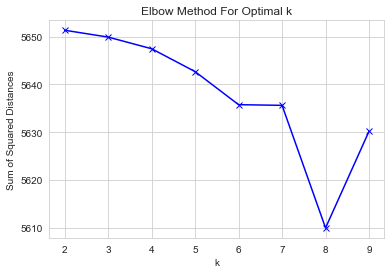

In [59]:
Sum_of_squared_distances = []
K = range(2,10)
for k in range(2,10):
    km = MiniBatchKMeans(n_clusters=k, max_iter=4000, n_init=500, random_state=1000) 
    km = km.fit(X_tfidf)
    print("For k =", k, " : ", km.inertia_)
    Sum_of_squared_distances.append(km.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Method For Optimal k')
plt.show()

According to the elbow method, the most promising values for the number of clusters are 4, 6, and 8. The code below clusters into 4 groups and then displays a word cloud from the descriptions in each cluster.

Select number of clusters and create a wordcloud of each category cluster.

2    5685
1      10
0       3
3       1
Name: category, dtype: int64
Category: 0


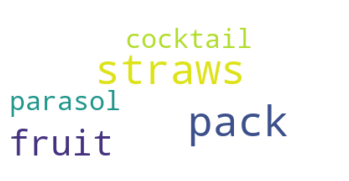

Category: 1


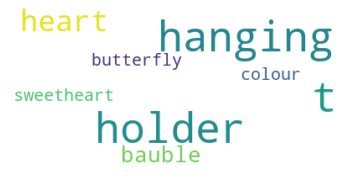

Category: 2


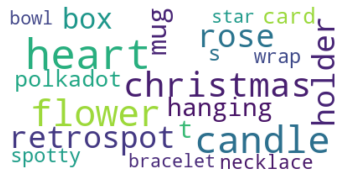

Category: 3


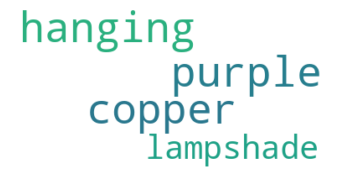

In [56]:
# set number of clusters
true_k = 4
# perform k-means clustering 
model = MiniBatchKMeans(n_clusters=true_k, init='k-means++', max_iter=4000, n_init=500, random_state=1000)
model.fit(X_tfidf)
# get cluster assignment for each item set
labels = model.labels_
tfidf_description_category = pd.DataFrame(list(zip(descriptions,labels)),columns=['Description','category'])
# print number of items per cluster
print(tfidf_description_category['category'].value_counts())

# create wordclouds for each cluster
for k in range(0,true_k):
    s=tfidf_description_category[tfidf_description_category.category==k]
    text=s['Description'].str.cat(sep=' ')
    text=text.lower()
    text=' '.join([word for word in text.split()])
    wordcloud = WordCloud(max_font_size=50, max_words=20, background_color="white",stopwords=custom_stopwords).generate(text)
    print('Category: {}'.format(k))
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

Seems that:
* category 0 is a quite general,
* category 1 is about bags
* category 2 is about christmas decoration
* category 3 is about other type of decoration

### B) Taking k = 6

4    5655
0      12
2      12
5      11
3       5
1       4
Name: category, dtype: int64
Category: 0


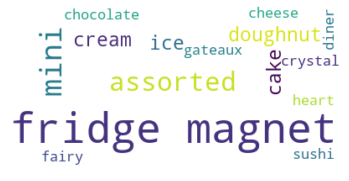

Category: 1


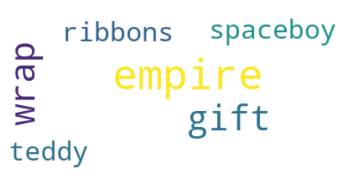

Category: 2


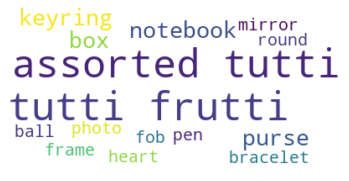

Category: 3


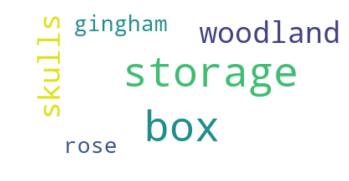

Category: 4


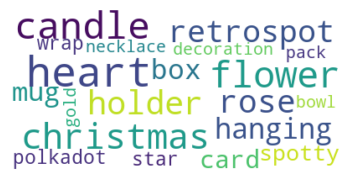

Category: 5


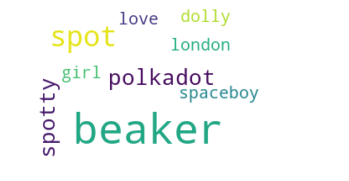

In [15]:
# set number of clusters
true_k = 6
# perform k-means clustering 
model = MiniBatchKMeans(n_clusters=true_k, init='k-means++', max_iter=4000, n_init=500, random_state=1000) 
#KMeans(n_clusters=true_k, init='k-means++', max_iter=4000, n_init=500, random_state=1000)
model.fit(X_tfidf)

# get cluster assignment for each item set
labels=model.labels_
tfidf_description_category=pd.DataFrame(list(zip(descriptions,labels)),columns=['Description','category'])

# print number of items per cluster
print(tfidf_description_category['category'].value_counts())

# create wordclouds for each cluster
for k in range(0,true_k):
    s=tfidf_description_category[tfidf_description_category.category==k]
    text=s['Description'].str.cat(sep=' ')
    text=text.lower()
    text=' '.join([word for word in text.split()])
    wordcloud = WordCloud(max_font_size=50, max_words=20, background_color="white",stopwords=custom_stopwords).generate(text)
    print('Category: {}'.format(k))
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

* category 0 is quite general,
* category 1 is about bags in this case too,
* category 2 is about aromatic candles,
* category 3 is about Christmas decoration,
* category 4 is about other types of decoration,
* category 5 is about cups, bowls, and plates.

### 2. Using CountVectorizer

Apply CountVectorizer on descriptions.

In [60]:
vectorizer = CountVectorizer(stop_words=custom_stopwords) #default stop_words={'english'}
X_countvect = vectorizer.fit_transform(descriptions) 
print(X_countvect.shape)

(5699, 2541)


Use elbow criterion for determining number of category clusters.

For k = 2  :  19152.511946401715
For k = 3  :  19148.35975510283
For k = 4  :  19127.161178452523
For k = 5  :  18845.083483040253
For k = 6  :  19085.285989475742
For k = 7  :  19094.41102131317
For k = 8  :  19012.144165005622
For k = 9  :  18710.393046318284


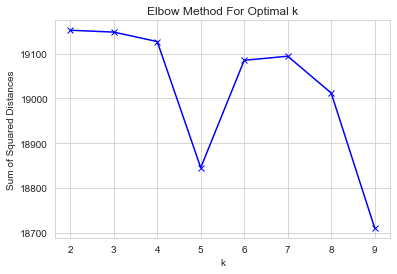

In [ ]:
Sum_of_squared_distances = []
K = range(2,10)
for k in range(2,10):
    km = MiniBatchKMeans(n_clusters=k, max_iter=4000, n_init=500, random_state=1000) 
    km = km.fit(X_countvect)
    print("For k =", k, " : ", km.inertia_)
    Sum_of_squared_distances.append(km.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Method For Optimal k')
plt.show()

Select number of clusters and create a wordcloud of each category cluster.

0    5690
2       6
1       3
Name: category, dtype: int64
Category: 0


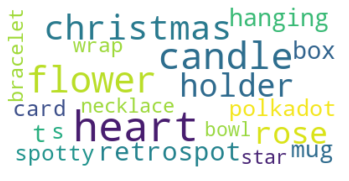

Category: 1


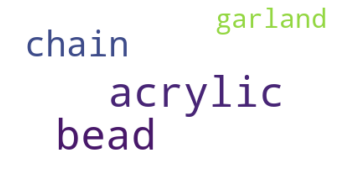

Category: 2


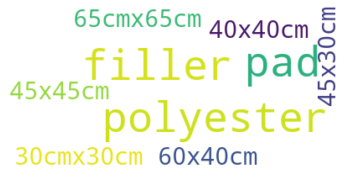

In [65]:
# set number of clusters
true_k = 3
# perform k-means clustering 
model = MiniBatchKMeans(n_clusters=true_k, init='k-means++', max_iter=4000, n_init=500, random_state=100)
model.fit(X_countvect)
# get cluster assignment for each item set
labels=model.labels_
countvec_description_category=pd.DataFrame(list(zip(descriptions,labels)),columns=['Description','category'])
# print number of items per cluster
print(countvec_description_category['category'].value_counts())

# create wordclouds for each cluster
for k in range(0,true_k):
    s=countvec_description_category[countvec_description_category.category==k]
    text=s['Description'].str.cat(sep=' ')
    text=text.lower()
    text=' '.join([word for word in text.split()])
    wordcloud = WordCloud(max_font_size=50, max_words=20, background_color="white",stopwords=custom_stopwords).generate(text)
    print('Category: {}'.format(k))
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

It seems that four clusters with TfidfVectorizer are more clear. We are going to use this.

Please note one should **try** using both TfidfVectorizer and CountVectorizer for various number of clusters, complete customer clustering with all of them and then **decide** which to keep.

## 4. Customer Segmentation

In this section we are going to add description categories to the data and use them for customer segmentation.

### 4.1 Adding description categories

In [86]:
tfidf_description_category.sample(5)

,Description,category
3898,Rusty,2
3569,BLUE NEW BAROQUE FLOCK CANDLESTICK,2
4040,BLUE WHITE PLASTIC RINGS LAMPSHADE,2
4790,Thrown away.,2
3652,PAPERWEIGHT CHILDHOOD MEMORIES,2


In [87]:
online_retail_categories = pd.merge(online_retail,tfidf_description_category,on='Description',how='inner')
online_retail_categories.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,category
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,2
1,C489518,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,-1,2009-12-01 11:35:00,7.95,15461.0,United Kingdom,2
2,C489528,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,-1,2009-12-01 11:50:00,7.95,16714.0,United Kingdom,2
3,C489551,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,-1,2009-12-01 12:35:00,6.95,17641.0,United Kingdom,2
4,489559,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 12:55:00,6.95,17056.0,United Kingdom,2


### 4.3 Feature Engineering -

After adding categories, for every row we calculate cost as the product of Quantity by Price.

In [91]:
online_retail_categories['cost'] = online_retail_categories['Quantity'] * online_retail_categories['Price']
online_retail_categories.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,category,yearmonth,cost
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,2,2009-12,83.40
1,C489518,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,-1,2009-12-01 11:35:00,7.95,15461.0,United Kingdom,2,2009-12,-7.95
2,C489528,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,-1,2009-12-01 11:50:00,7.95,16714.0,United Kingdom,2,2009-12,-7.95
3,C489551,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,-1,2009-12-01 12:35:00,6.95,17641.0,United Kingdom,2,2009-12,-6.95
4,489559,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 12:55:00,6.95,17056.0,United Kingdom,2,2009-12,83.40


### 4.3 Calculate cost per category per month

With this data, we are able to calculate cost per category per month. Note that in category 2 there is a sharp increase on November while it is close to zero during the rest months. This verifies that category 2 has to do with Christmas related products. 

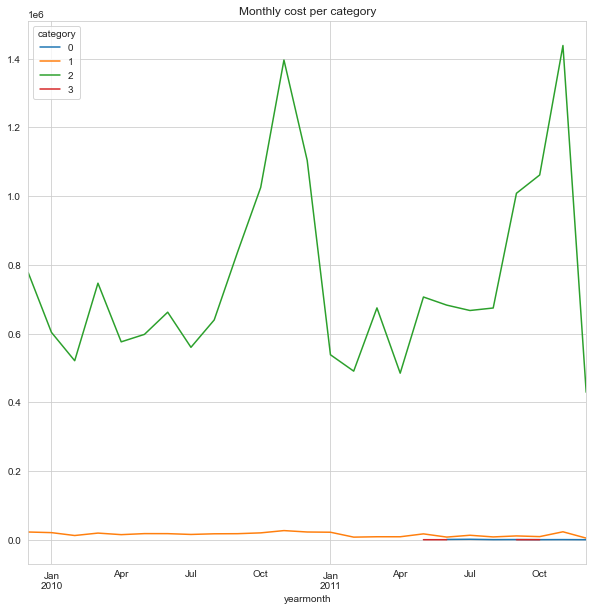

In [92]:
categories_per_date = online_retail_categories
categories_per_date['yearmonth'] = online_retail_categories['InvoiceDate'].dt.to_period('M')
categories_per_date=categories_per_date.pivot_table(index=['yearmonth'], 
                    columns='category', 
                    values='cost',
                  #margins=True,  # add margins
                    aggfunc='sum').reset_index()
#categories_per_date.head()
lines=categories_per_date.plot.line(x="yearmonth", y=[0,1,2,3],figsize=(10,10),title='Monthly cost per category')
plt.show()

### 4.4 Calculate total spending (cost) per category

Next, we calculate total spending (cost) per category for every customer.

In [71]:
customer_spending_per_category=online_retail_categories.pivot_table(index=["Customer ID"], 
                    columns='category', 
                    values='cost',
                   # margins=True,  # add margins
                    aggfunc='sum').reset_index()
customer_spending_per_category.head()

category,Customer ID,0,1,2,3
0,12346.0,NaN,NaN,-64.68,NaN
1,12347.0,NaN,NaN,5633.32,NaN
2,12348.0,NaN,NaN,2019.40,NaN
3,12349.0,NaN,NaN,4404.54,NaN
4,12350.0,NaN,NaN,334.40,NaN


In [72]:
customer_spending_per_category=customer_spending_per_category.fillna(0)
customer_spending_per_category.head()

category,Customer ID,0,1,2,3
0,12346.0,0.0,0.0,-64.68,0.0
1,12347.0,0.0,0.0,5633.32,0.0
2,12348.0,0.0,0.0,2019.40,0.0
3,12349.0,0.0,0.0,4404.54,0.0
4,12350.0,0.0,0.0,334.40,0.0


In [93]:
customer_spending_per_category.describe()

category,Customer ID,0,1,2,3
count,5942.000000,5942.000000,5942.000000,5942.000000,5942.000000
mean,15316.500000,0.000120,0.019439,0.976905,0.000002
std,1715.451981,0.001570,0.054936,0.080013,0.000098
min,12346.000000,0.000000,0.000000,0.000000,0.000000
25%,13831.250000,0.000000,0.000000,0.984031,0.000000
50%,15316.500000,0.000000,0.000000,1.000000,0.000000
75%,16801.750000,0.000000,0.015052,1.000000,0.000000
max,18287.000000,0.071237,1.000000,1.000000,0.007351


Finally, we will replace total cost per category with the percentage to the total cost across all categories. Notice, that in some cases, we have negative values. Probably this signifies returns. Since an item that is returned should have been bought in a previous time, we change negative values to positive. 

In [94]:
customer_spending_per_category['total']=abs(customer_spending_per_category[0])+abs(customer_spending_per_category[1])+abs(customer_spending_per_category[2])+abs(customer_spending_per_category[3])
# if total is 0 reset it to 1, otherwise NaNs will appear when dividing by total
customer_spending_per_category.loc[customer_spending_per_category['total']==0,'total']=1
customer_spending_per_category[0]=abs(customer_spending_per_category[0])/customer_spending_per_category['total']
customer_spending_per_category[1]=abs(customer_spending_per_category[1])/customer_spending_per_category['total']
customer_spending_per_category[2]=abs(customer_spending_per_category[2])/customer_spending_per_category['total']
customer_spending_per_category[3]=abs(customer_spending_per_category[3])/customer_spending_per_category['total']
customer_spending_per_category=customer_spending_per_category.drop(['total'],axis=1)
customer_spending_per_category.fillna(0)
customer_spending_per_category.head()

category,Customer ID,0,1,2,3
0,12346.0,0.0,0.0,1.0,0.0
1,12347.0,0.0,0.0,1.0,0.0
2,12348.0,0.0,0.0,1.0,0.0
3,12349.0,0.0,0.0,1.0,0.0
4,12350.0,0.0,0.0,1.0,0.0


## 5. Customer clustering
This is the section with the actual customer clustering.

### 5.1 K-Means
We scale the input matrix and use the elbow method to decide the number of `customer clusters`.

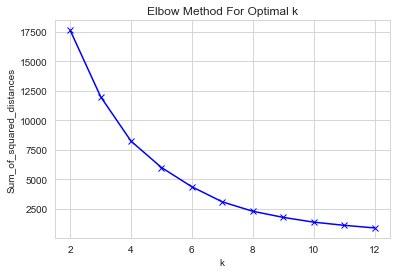

In [95]:
scaler = StandardScaler()
X_std = scaler.fit_transform(customer_spending_per_category.drop(['Customer ID'], axis=1))
Sum_of_squared_distances = []
K = range(2,13)
for k in K:
    km = KMeans(n_clusters=k, max_iter=5000, n_init=500, random_state=100) 
    km = km.fit(X_std)
    Sum_of_squared_distances.append(km.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

##### Selecting 4 as the number of clusters.

In [96]:
# set number of clusters
true_k =4
# perform k-means clustering 
model = KMeans(n_clusters=true_k, max_iter=5000, n_init=500, random_state=100) 
model.fit(X_std)
# append cluster assignment for each item set
customer_spending_per_category['cluster'] = model.labels_
# print number of items per cluster
print(customer_spending_per_category['cluster'].value_counts())
customer_spending_per_category['cluster'] = model.labels_

0    5816
2     119
3       6
1       1
Name: cluster, dtype: int64


Function cluster_profile will be used to profile clusters.

category Customer ID         0         1         2         3
               count    median    median    median    median
cluster                                                     
0               5816  0.000000  0.000000  1.000000  0.000000
1                  1  0.000000  0.000000  0.992649  0.007351
2                119  0.000000  0.247373  0.692067  0.000000
3                  6  0.030033  0.000000  0.951604  0.000000




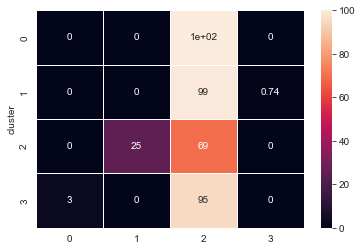

In [98]:
def cluster_profile(customer_spending_per_category):
  ''' profile clusters '''
  customer_clusters=customer_spending_per_category.groupby(['cluster']).agg({'Customer ID':['count'], 
                                                         0:'median',
                                                         1:'median',
                                                         2:'median',
                                                         3:'median'})
  print(customer_clusters)
  print('\n')
  customer_clusters=customer_clusters.drop([('Customer ID', 'count')],axis = 1)
  customer_clusters.columns=[0,1,2,3]
  
  customer_clusters[0]=100*customer_clusters[0]
  customer_clusters[1]=100*customer_clusters[1]
  customer_clusters[2]=100*customer_clusters[2]
  customer_clusters[3]=100*customer_clusters[3]
  

  sns.heatmap(customer_clusters, annot=True,  linewidths=0.5)

cluster_profile(customer_spending_per_category)

We see that for all clusters there is a high percentage of spending in category 0. In addition:
* cluster 0 has customer with high spending in category 2,
* cluster 1 has high spending only in category 0,
* cluster 2 has customer with high spending in category 3,
* cluster 3 has customer with high spending in category 1.


In [99]:
customer_spending_per_category_k_Means = customer_spending_per_category.copy()

##### Selecting 6 as the number of clusters.

In [100]:
# set number of clusters
true_k = 6
# perform k-means clustering 
model = KMeans(n_clusters=true_k, max_iter=5000, n_init=500, random_state=100) 
model.fit(X_std)
# append cluster assignment for each item set
customer_spending_per_category['cluster']=model.labels_
# print number of items per cluster
print(customer_spending_per_category['cluster'].value_counts())

0    5299
3     565
5      50
1      21
4       6
2       1
Name: cluster, dtype: int64


category Customer ID         0         1         2         3
               count    median    median    median    median
cluster                                                     
0               5299  0.000000  0.000000  1.000000  0.000000
1                 21  0.000000  0.000000  0.000000  0.000000
2                  1  0.000000  0.000000  0.992649  0.007351
3                565  0.000000  0.089848  0.910152  0.000000
4                  6  0.030033  0.000000  0.951604  0.000000
5                 50  0.000000  0.367738  0.632262  0.000000




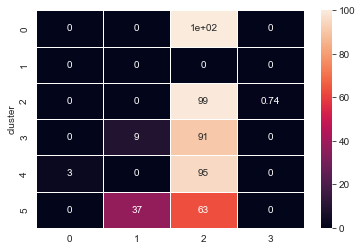

In [101]:
cluster_profile(customer_spending_per_category)

We see that we get clusters with higher percentage in category 1 or category 2 than category 0.

### 5.2 Hierachical clustering
Using hierachical clustering we can gain a better understanding of the possible number of clusters.

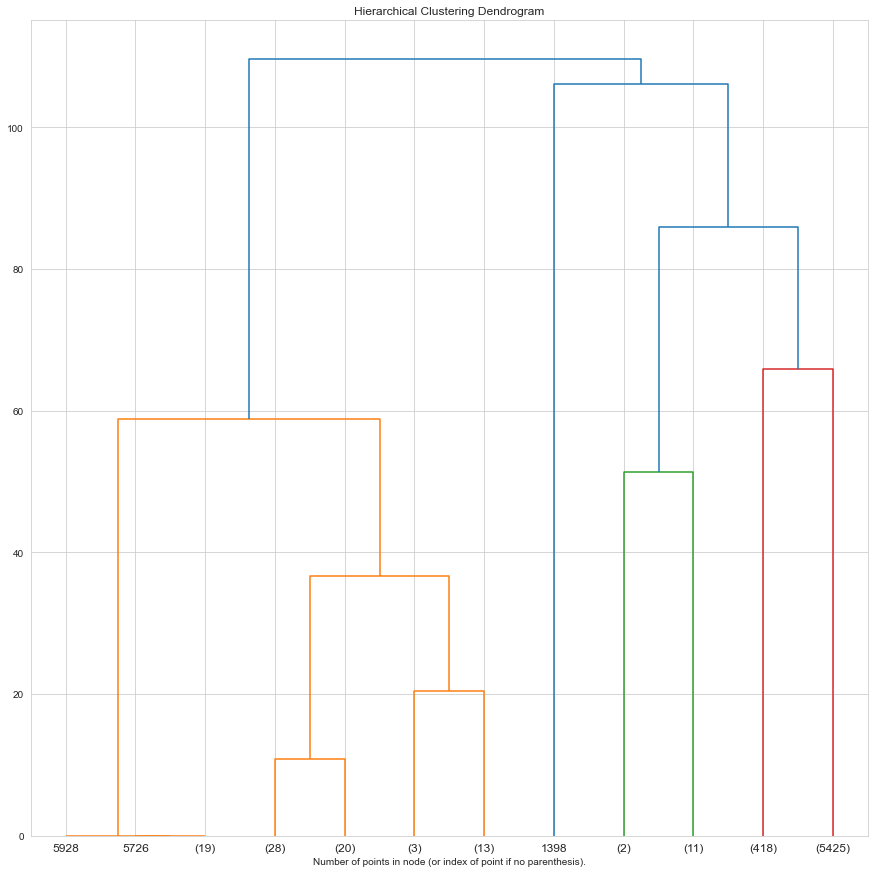

In [102]:
# source https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)



# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None,linkage='ward')

model = model.fit(X_std)
plt.figure(figsize=(15,15))
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode='level', p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

##### Selecting 4 as the number of clusters.

In [103]:
model = AgglomerativeClustering(n_clusters=4,linkage='ward')
model.fit(X_std)
# append cluster assignment for each item set
customer_spending_per_category['cluster']=model.labels_
# print number of items per cluster
print(customer_spending_per_category['cluster'].value_counts())

0    5843
1      85
3      13
2       1
Name: cluster, dtype: int64


category Customer ID         0         1         2         3
               count    median    median    median    median
cluster                                                     
0               5843  0.000000  0.000000  1.000000  0.000000
1                 85  0.000000  0.291188  0.609272  0.000000
2                  1  0.000000  0.000000  0.992649  0.007351
3                 13  0.019147  0.000000  0.952954  0.000000




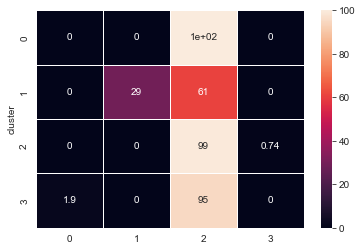

In [104]:
cluster_profile(customer_spending_per_category)

We observe that, now, the cluster with high spending in category 1 (cluster 3) has higher spending in category 1 than in category 0. This inversion is a result its smaller size. 

We will store the results of k-means clustering into 4 clusters.

In [105]:
customer_spending_per_category_k_Means.to_pickle('customer_segments_buying_categories.pickle')

In [38]:
from google.colab import files
files.download('customer_segments_buying_categories.pickle') 


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# load with
# customer_spending_per_category = pd.read_pickle(file_name)